In [8]:
#!pip list


In [9]:
#!pip install opencv-python matplotlib imageio gdown tensorflow


In [10]:
#!pip install --upgrade tensorflow


In [11]:
import os
import cv2
import tensorflow as tf
import numpy as np 
from PIL import Image
from typing import List
from matplotlib import pyplot as plt
import imageio


In [12]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [13]:
tf.config.list_physical_devices('GPU')

[]

In [14]:
#Build data loading fuctions
import gdown

In [15]:
#url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
#output = 'data.zip'
#gdown.download(url,output, quiet=False)
#gdown.extractall('data.zip')

In [16]:
def load_video(path:str) -> List[float]:
    
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32
                                    ))
    return tf.cast((frames - mean), tf.float32) / std

In [17]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [18]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [19]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(f"The vocabulary is: {char_to_num.get_vocabulary()}"
      f"(size = {char_to_num.vocabulary_size()})"
)


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [20]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding = 'UTF-8'),(-1)))[1:]

In [21]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments 

In [22]:
test_path = '.\\data\\s1\\bbaf2n.mpg'

In [23]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbaf2n'

In [24]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

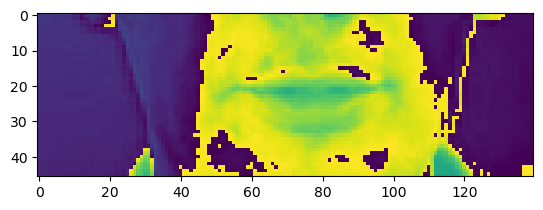

In [25]:
plt.imshow(frames[40])

In [26]:
print ([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'f', ' ', 't', 'w', 'o', ' ', 'n', 'o', 'w']


In [27]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data,[path], (tf.float32, tf.int64))
    return result                       

In [28]:
#Creating the data pipeline
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)


In [29]:
frames, alignments = data.as_numpy_iterator().next()

In [30]:
frames

array([[[[[ 1.3572764 ],
          [ 1.3572764 ],
          [ 1.3971964 ],
          ...,
          [ 0.19959949],
          [ 0.11975969],
          [ 0.11975969]],

         [[ 1.3572764 ],
          [ 1.3572764 ],
          [ 1.3971964 ],
          ...,
          [ 0.19959949],
          [ 0.11975969],
          [ 0.11975969]],

         [[ 1.3572764 ],
          [ 1.3572764 ],
          [ 1.3572764 ],
          ...,
          [ 0.19959949],
          [ 0.11975969],
          [ 0.11975969]],

         ...,

         [[ 0.8782377 ],
          [ 0.8782377 ],
          [ 0.8782377 ],
          ...,
          [10.139654  ],
          [10.0598135 ],
          [10.0598135 ]],

         [[ 0.8782377 ],
          [ 0.8782377 ],
          [ 0.8782377 ],
          ...,
          [10.139654  ],
          [10.0598135 ],
          [10.0598135 ]],

         [[ 0.8383178 ],
          [ 0.8383178 ],
          [ 0.8383178 ],
          ...,
          [10.139654  ],
          [10.0598135 ],
          

In [31]:
len(test)

50

In [32]:
sample = data.as_numpy_iterator()

In [33]:
val = sample.next(); val[0]

array([[[[[1.4100399 ],
          [1.4100399 ],
          [1.4100399 ],
          ...,
          [0.19054593],
          [0.15243675],
          [0.15243675]],

         [[1.4100399 ],
          [1.4100399 ],
          [1.4100399 ],
          ...,
          [0.19054593],
          [0.15243675],
          [0.15243675]],

         [[1.3338215 ],
          [1.3338215 ],
          [1.3338215 ],
          ...,
          [0.19054593],
          [0.15243675],
          [0.15243675]],

         ...,

         [[0.91462046],
          [0.91462046],
          [0.91462046],
          ...,
          [9.603515  ],
          [9.603515  ],
          [9.603515  ]],

         [[0.91462046],
          [0.91462046],
          [0.91462046],
          ...,
          [9.603515  ],
          [9.603515  ],
          [9.603515  ]],

         [[0.91462046],
          [0.91462046],
          [0.91462046],
          ...,
          [9.603515  ],
          [9.603515  ],
          [9.603515  ]]],


        [[[1.3719

In [34]:
frames_float32 = val[0][1]

In [35]:
frames_uint8 = (frames_float32 * 255).astype(np.uint8)

In [36]:
frames_uint8 = np.squeeze(frames_uint8)

In [37]:

imageio.mimsave('./animation.gif', frames_uint8, duration=100)



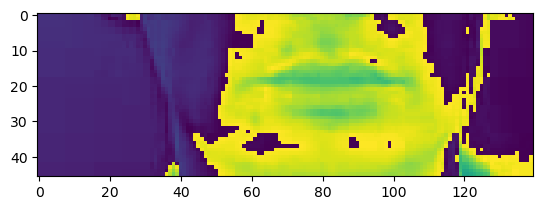

In [38]:
plt.imshow(val[0][0][0])

In [39]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue by b one again'>

In [40]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [41]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75, 46, 140, 1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1, 2, 2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True), input_shape=(75, 46, 140, 1)))
model.add(Dropout(0.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True), input_shape=(75, 46, 140, 1)))
model.add(Dropout(0.5))

# Assuming char_to_num is a tokenization utility
model.add(Dense(char_to_num.vocabulary_size() + 1, kernel_initializer='he_normal', activation='softmax'))

In [42]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [45]:
yhat = model.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [46]:
tf.strings.reduce_join([num_to_char(tf.argmax(x))for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'118811111111111111111111111111!!777711111117!!!!!!!!!!!!!!777777777772rrrrr'>

In [47]:
model.input_shape


(None, 75, 46, 140, 1)

In [48]:
model.output_shape

(None, 75, 41)

In [49]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [50]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [51]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [52]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [53]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 


In [54]:
schedule_callback = LearningRateScheduler(scheduler)

In [55]:
example_callback = ProduceExample(test)

In [56]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100

  1/450 [..............................] - ETA: 2:16:54 - loss: 239.3773

KeyboardInterrupt: 

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
#Test on a video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]